These are notes on using polynomial regression and step functions.  These are taken from 
- [Machine Learning 293 from Smith College by R. Jordan Crouser](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab12-py.html)
- [Intro to Statistical Learning with Applications in R](http://faculty.marshall.usc.edu/gareth-james/ISL/)

#### Polynomial Regression

Polynomial regression is used to extend linear regression in which the relationship between your predictors and target is non-linear.  Below I am going to show an example of trying four different versions of polynomial regression. 

In [10]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/datasets/master/Wage.csv')
df.head()

,year,age,maritl,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


Apply polynomial regression to the age column 

In [11]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))

Fit a model using the age column 

In [55]:
fit1 = sm.GLS(df.wage, X1).fit()
fit2 = sm.GLS(df.wage, X2).fit()
fit3 = sm.GLS(df.wage, X3).fit()
fit4 = sm.GLS(df.wage, X4).fit()


# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)


# Predict the value of the generated ages
pred1 = fit1.predict(PolynomialFeatures(1).fit_transform(age_grid))
pred2 = fit2.predict(PolynomialFeatures(2).fit_transform(age_grid))
pred3 = fit3.predict(PolynomialFeatures(3).fit_transform(age_grid))
pred4 = fit4.predict(PolynomialFeatures(4).fit_transform(age_grid))

Plot out the model fits 

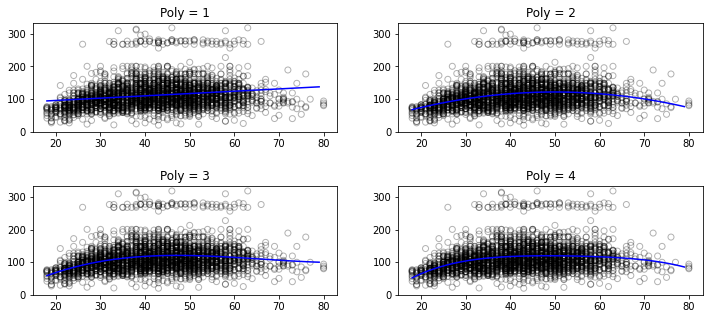

In [48]:
fig, ax = plt.subplots(2,2, figsize = (12,5))

ax[0][0].scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax[0][0].plot(age_grid, pred1, color = 'b')
ax[0][0].set_ylim(ymin=0)
ax[0][0].set_title('Poly = 1')

ax[0][1].scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax[0][1].plot(age_grid, pred2, color = 'b')
ax[0][1].set_ylim(ymin=0)
ax[0][1].set_title('Poly = 2')

ax[1][0].scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax[1][0].plot(age_grid, pred3, color = 'b')
ax[1][0].set_ylim(ymin=0)
ax[1][0].set_title('Poly = 3')

ax[1][1].scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax[1][1].plot(age_grid, pred4, color = 'b')
ax[1][1].set_ylim(ymin=0)
ax[1][1].set_title('Poly = 4')

fig.subplots_adjust(hspace=.5)

### Step Functions 

Step functions can be used to fit different models to different parts of the data.  I am going to put the age column into 4 different bins. 

In [60]:
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [61]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys = ['age','age_cuts','wage'], axis = 1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

# Drop the (17.938, 33.5] category
df_steps_dummies = df_steps_dummies.drop(df_steps_dummies.columns[1], axis = 1)

df_steps_dummies.head(5)

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,1,0,0
3,1.0,1,0,0
4,1.0,0,1,0


In [62]:
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()

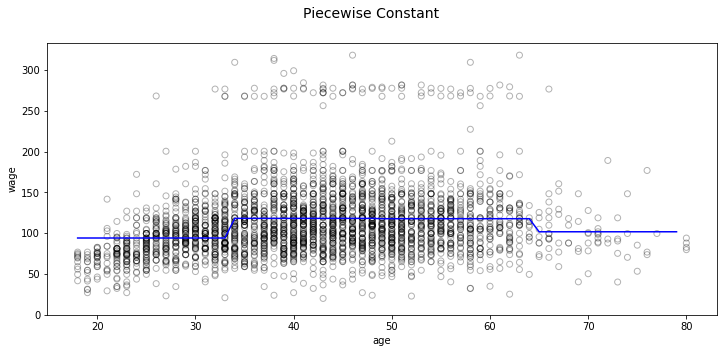

In [63]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1))

# Predict the value of the generated ages using the linear model
pred2 = fit3.predict(X_test2)

# Plot
fig, ax = plt.subplots(figsize = (12,5))
fig.suptitle('Piecewise Constant', fontsize = 14)

# Scatter plot with polynomial regression line
ax.scatter(df.age, df.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax.plot(age_grid, pred2, c = 'b')

ax.set_xlabel('age')
ax.set_ylabel('wage')
ax.set_ylim(ymin = 0);